# Infos

- Pre-process using an 8–30 Hz filter and a notch filter
- Sampled at 125 Hz

# Imports

In [1]:
import os
import random
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Check if we have CUDA support

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060
Total memory: 12.0 GB


# Dataset

## Download from Drive

In [3]:
downloadDataset = False

if(downloadDataset):
    EEG_Dataset_URL = 'https://drive.google.com/uc?id=' + '1Ijm2rxaGksYbnl1AQIYdConiNMrA1N0R' + '&export=download&confirm=t'
    EEG_zip_name = "EEG_Dataset_Final.zip"
    extracted_dir = "Dataset/"

    gdown.download(EEG_Dataset_URL, EEG_zip_name, quiet=False)

    # Create a ZipFile object and open the ZIP file
    with zipfile.ZipFile(EEG_zip_name, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extracted_dir)

    print(f"Files extracted to {extracted_dir}")

    os.remove(EEG_zip_name)

## Helper functions

In [4]:
# First, get the electrodes positions for each subject starting from the TSV files
# This is needed to correctly name the column in the Pandas Dataframe that will be created later
def get_electrodes_positions(mode = 'Unhealthy', mapping: dict = None):
    selected_files = []

    for _, values in mapping.items():
        for value in values:
            for run in range(1, 13):  # Assuming runs go from 1 to 13
                filename = f"Dataset/{mode}/{value}_task-motion_run-{run}_electrodes.tsv"
                if os.path.exists(filename):
                    selected_files.append(filename)
                    break  # Break the loop once a file is found for the subject
                else:
                    filename = f"Dataset/{mode}/{value}_task-motorimagery_run-{run}_electrodes.tsv"
                    if os.path.exists(filename):
                        selected_files.append(filename)
                        break
            if filename in selected_files:
                break  # Break the outer loop if a file is found for the subject
    return selected_files

# Concatenate all DataFrames in the list into a single DataFrame
# This is done for both the Unhealthy and Healthy datasets
def get_final_csv(mode = 'Unhealthy', subject = 'S1'):
    # Various lists to store the dataframes
    dfs = []
    file_paths = []

    # Get file paths and reorder them
    file_paths = [f"Dataset/{mode}/{file}" for file in os.listdir(f"Dataset/{mode}/") if file.startswith(subject) and file.endswith(".csv")]

    # Read each CSV file into a DataFrame and append it to the list
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    return concatenated_df

# Convert the labels from string to numerical classes
def convert_labels(df: pd.DataFrame):
    label_encoder = LabelEncoder() # Use LabelEncoder to convert string labels to numerical classes
    df['Label'] = label_encoder.fit_transform(df.iloc[:, -2].values) # Update the DataFrame with the encoded labels
    return df

# Reorder columns based on the TSV files
def reorder_columns(df: pd.DataFrame, mode = 'Unhealthy', electrodes_locations = None):
    # Get the column names
    cols = list(df.columns)

    # If in 'Unhealthy' mode, move 'Label' to the end as it should be
    if mode == 'Unhealthy':
        del cols[cols.index('labels')]
        cols.append('labels')

    # Reorder the columns
    df = df[cols]

    # Load corresponding electrodes file and set column names
    channel_dataframe = pd.read_csv(electrodes_locations[0], sep='\t')

    # Append 'Label' to the end of the column names and feed it to the DataFrame
    if mode == 'Unhealthy':
        # Only consider until the second last column because no CSV has that channel location (Pz)
        # It would've thrown an error otherwise because it would've tried to rename a column that doesn't exist
        channel_column = np.append((channel_dataframe.iloc[:, 0].values)[:-1], 'Label')

        # Change column names to reflect the actual channel names
        name_mapping = {'CP1': 'Cp1',
                        'CP2': 'Cp2',
                        'CP5': 'Cp5',
                        'CP6': 'Cp6',
                        'FC1': 'Fc1',
                        'FC2': 'Fc2',
                        'FC5': 'Fc5',
                        'FC6': 'Fc6'}
        
        # Replace the names in the array
        for key, value in name_mapping.items():
            channel_column = np.where(channel_column == key, value, channel_column)
            
        final_channel_names = channel_column
    else:
        final_channel_names = np.append(channel_dataframe.iloc[:, 0].values, 'Label')

    df.columns = final_channel_names
    return df

## Get electrodes positions

In [5]:
mapping = {
    "S1": ["sub-001", "sub-01"],
    "S2": ["sub-003", "sub-02"],
    "S3": ["sub-009", "sub-03"],
    "S4": ["sub-022", "sub-04"],
    "S5": ["sub-039", "sub-05"],
    "S6": ["sub-040", "sub-06"],
    "S7": ["sub-058", "sub-07"],
}

unhealthy_electrodes = get_electrodes_positions(mode='Unhealthy', mapping=mapping)
healthy_electrodes = get_electrodes_positions(mode='Healthy', mapping=mapping)

print("Unhealthy electrodes:")
for electrode in unhealthy_electrodes:
    print(electrode)
print("---------------------")
print("Healthy electrodes:")
for electrode in healthy_electrodes:
    print(electrode)
print("---------------------")

Unhealthy electrodes:
Dataset/Unhealthy/sub-01_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-02_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-03_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-04_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-05_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-06_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-07_task-motorimagery_run-1_electrodes.tsv
---------------------
Healthy electrodes:
Dataset/Healthy/sub-001_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-003_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-009_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-022_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-039_task-motion_run-5_electrodes.tsv
Dataset/Healthy/sub-040_task-motion_run-3_electrodes.tsv
Dataset/Healthy/sub-058_task-motion_run-2_electrodes.tsv
---------------------


## Get the corresponding CSV for each subject

In [6]:
# Get all the CSVs for each subject and concatenate them into a single DataFrame
# This is done for both Healthy and Unhealthy datasets.
# -----------------------------------------------
dfs = []
dfs_unhealthy = []
final_df = None
final_df_unhealthy = None

for key, value in tqdm(mapping.items(), desc="Processing CSVs"):
    # print("-----------------------------------------------")
    # print("Subject: ", key)
    # print("-----------------------------------------------")
    dataframe_sub = get_final_csv(mode='Healthy', subject = key)
    dataframe_sub_unhealthy = get_final_csv(mode='Unhealthy', subject = key)
    # Display the first few rows of the DataFrame to inspect the data
    #print("-----------------------------------------------")
    #print(F"Features example:\n{dataframe_sub.iloc[0, :-1].values} ")
    #print(F"Dataframe shape: {dataframe_sub.shape}")
    #print("-----------------------------------------------")
    dfs.append(dataframe_sub)
    dfs_unhealthy.append(dataframe_sub_unhealthy)

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df_unhealthy = pd.concat(dfs_unhealthy, ignore_index=True)

# Reorder columns based on the TSV files
final_df = reorder_columns(final_df, mode='Healthy', electrodes_locations=healthy_electrodes)
final_df_unhealthy = reorder_columns(final_df_unhealthy, mode='Unhealthy', electrodes_locations=unhealthy_electrodes)

# Add a column to the DataFrame to indicate the condition (Healthy or Unhealthy)
#   - Healthy = 0
#   - Unhealthy = 1
final_df['Condition'] = 0
final_df_unhealthy['Condition'] = 1

print("---------------- H E A L T H Y ----------------")
print(F"Features example:\n{final_df.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df.iloc[0, -2]} ")
print(F"Condition example:\n{final_df.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-------------- U N H E A L T H Y --------------")
print(F"Features example:\n{final_df_unhealthy.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df_unhealthy.iloc[0, -2]} ")
print(F"Condition example:\n{final_df_unhealthy.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df_unhealthy.shape}")
print("-----------------------------------------------")

Processing CSVs: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

---------------- H E A L T H Y ----------------
Features example:
[-47.12606 -40.03687 -28.43023 -15.80705 -15.40239 -17.39325 -6.753483
 -41.71441 -29.61547 -29.06108 -16.57224 2.722057 -1.055834 8.80013
 -25.22816 -19.57724 -21.90762 -8.712437 -2.123052 9.455163 10.48133
 -108.5048 -95.02638 -92.54481 -99.00912 -92.79308 -57.25875 -92.83072
 -118.9474 -66.048 -45.74461 -18.30413 -55.5227 -39.46687 -39.35728
 -64.74155 -67.0032 -91.47729 -66.98862 -15.40147 -30.76247 19.59843
 -29.16073 -3.518085 -50.16245 17.82572 -28.91558 -12.00647 -3.965302
 0.2382838 6.104471 22.59003 16.41057 13.79746 24.66558 2.523039 4.559081
 23.84749 39.26994 17.12286 43.16951 25.42886 78.28799 43.73438]
Motor task example:
BASE2T0 
Condition example:
0 
-----------------------------------------------
Dataframe shape: (13097, 66)
-------------- U N H E A L T H Y --------------
Features example:
[-10.91762 -2.02933 7.096577 -26.63925 26.39317 -26.48929 26.99162
 -26.50284 -3.303668 -18.22219 -7.450249 -11.549

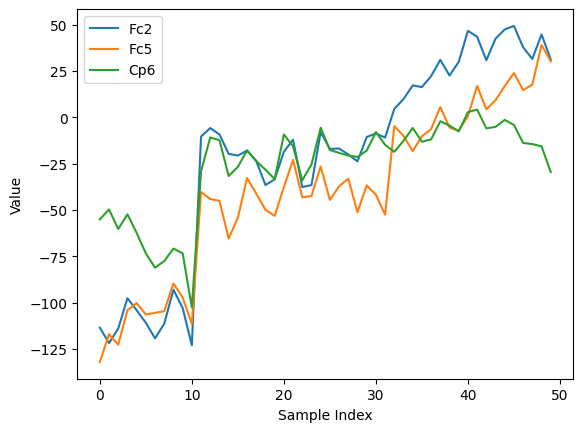

In [48]:
# Plotting example
fc2_electrode = 'Fc2'
fc5_electrode = 'Fc5'
cp6_electrode = 'Cp6'
len_signal = 50

# Plot for healthy data
plt.figure(figsize=(20, 6))
plt.suptitle("Fc2 / Fc5 / Cp6 CHANNELS")

plt.subplot(1, 2, 1)
plt.plot(merged_df[merged_df['Condition'] == 0][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Healthy')
plt.legend()

# Plot for non-healthy data
plt.subplot(1, 2, 2)
plt.plot(merged_df[merged_df['Condition'] == 1][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Non-Healthy')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Get the actual Dataloader

In [49]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe.values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Features (until last column)
        features = torch.tensor(self.data[idx, :-1], dtype=torch.float32)

        # Label (last column)
        label = torch.tensor(self.data[idx, -1], dtype=torch.float32)

        return features, label

In [51]:
scaler = MinMaxScaler()
labels = final_df.iloc[:, -1]

# Scale the features between 0 and 1 and concatenate them with the labels
df_scaled = pd.DataFrame(scaler.fit_transform(final_df.iloc[:, :-1]))

finalDf = pd.concat([df_scaled, labels], axis=1)
finalDf = finalDf.dropna()  # Remove rows with NaN values

assert not finalDf.isna().any().any(), "finalDf contains NaN values"

train_df, test_df = train_test_split(finalDf, test_size=0.2, random_state=2047315)

# Create custom datasets and data loaders
train_dataset = CustomDataset(pd.DataFrame(train_df))
test_dataset = CustomDataset(pd.DataFrame(test_df))

batch_size = 64 # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")
print("------------------------------------------------------")
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")
print("------------------------------------------------------")
batch = next(iter(train_loader))
print(f"Shape of batch (X): {batch[0].shape}")
print(f"Shape of batch (y): {batch[1].shape}")

Number of samples in train dataset: 10477
Number of samples in test dataset: 2620
------------------------------------------------------
Number of batches in train loader: 164
Number of batches in test loader: 41
------------------------------------------------------
Shape of batch (X): torch.Size([64, 64])
Shape of batch (y): torch.Size([64])


# Model

In [52]:
class CVAE(nn.Module):
    def __init__(self, num_features, latent_dim, output_dim, condition_dim):
        super(CVAE, self).__init__()

        # Encoder
        #self.fc1 = nn.Linear(num_features + condition_dim, 512)
        self.fc1 = nn.Linear(num_features, 64, device=device)
        self.fc2 = nn.Linear(64, 32, device=device)

        self.fc_mu = nn.Linear(32, latent_dim, device=device)
        self.fc_logvar = nn.Linear(32, latent_dim, device=device)

        # Decoder
        #.fc3 = nn.Linear(latent_dim + condition_dim, 256)
        self.fc3 = nn.Linear(latent_dim, 32, device=device)
        self.fc4 = nn.Linear(32, 64, device=device)

        self.fc_output = nn.Linear(64, output_dim, device=device)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_mu(x), self.fc_logvar(x)

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc_output(z))

    # Take the mean (mu - μ) and log-variance (log(2)log(σ2)) produced by the Encoder 
    # and generates a latent code z using the reparameterization trick.
    # This process ensures that the sampling operation is differentiable,
    # enabling the use of backpropagation during training.
    def reparameterize(self, mu, logvar):
        # The standard deviation (std) is calculated as the 
        # exponential of half of the log-variance.
        # This ensures that std is positive.
        std = torch.exp(0.5 * logvar)

        # Generates random noise with the same shape as the computed standard deviation.
        # This noise is sampled from a normal distribution with mean 0 and standard deviation 1.
        eps = torch.randn_like(std)
        return mu + eps * std # μ + σ ⊙ ϵ

    def forward(self, x, condition=None):
        #x = torch.cat([x, condition], dim=1)    # Add the condition to Encoder - CVAE ---> TODO
        
        mu, logvar = self.encode(x)             # Encoding

        z = self.reparameterize(mu, logvar)     # Re-parametrization | Latent variable

        #z = torch.cat([z, condition], dim=1)    # Add the condition to Decoder - CVAE ---> TODO
        reconstructed_x = self.decode(z)        # Decoding
        return reconstructed_x, mu, logvar

In [53]:
num_features = batch[0].shape[1]    # 64 -> Number of features in the CSV
latent_dim = 16                     # Latent space dimension
output_dim = batch[0].shape[1]      # Output dimension (same as input for reconstruction)
condition_dim = 1                   # Dimension of the conditional variable (4 classes)

cvae = CVAE(num_features, latent_dim, output_dim, condition_dim)
cvae = cvae.to(device=device)
print(cvae)

CVAE(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=64, bias=True)
)


In [ ]:
# Example usage
num_epochs = 50

# Define your loss function and optimizer
criterion = nn.MSELoss()  # You can choose a different loss function based on your task

# Define your optimizer
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)  # You can adjust the learning rate based on your needs

# Training loop
for epoch in tqdm(range(num_epochs), desc=F"Epochs (Train)", leave=True):

    # Train CVAE
    cvae.train()

    losses = []  # Store the loss of each batch in this list

    for i, (x, labels) in enumerate(train_loader):

        # We need to move to the GPU
        x = x.to(device=device)
        labels = labels.to(device=device)

        # Forward pass
        reconstructed_data, mu, logvar = cvae(x, None)

        # Assuming reconstructed_x is the output of your CVAE, input_x is the input data
        reconstruction_loss = criterion(reconstructed_data, x)

        # KL Divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Compute the mean and standard deviation of the losses
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)

    if(epoch % 5 == 0):
        print(f"Epoch {epoch} | Mean Loss = {mean_loss:.3f} | Std Loss = {std_loss:.3f}")

Generated samples:
	tensor([[0.4000, 0.4840, 0.4800, 0.4897, 0.4086, 0.4530, 0.5227, 0.4969, 0.5523,
         0.5231, 0.4768, 0.5553, 0.5072, 0.4929, 0.5262, 0.5046, 0.5156, 0.4433,
         0.4674, 0.4999, 0.4748, 0.3908, 0.3968, 0.4110, 0.4273, 0.3527, 0.4105,
         0.3751, 0.4190, 0.4020, 0.4270, 0.3563, 0.4186, 0.3681, 0.4101, 0.3959,
         0.4566, 0.3916, 0.5560, 0.4372, 0.3966, 0.5058, 0.5350, 0.4875, 0.5462,
         0.4206, 0.4506, 0.5619, 0.4455, 0.5124, 0.5184, 0.5294, 0.5219, 0.4095,
         0.5069, 0.4296, 0.5526, 0.5292, 0.5285, 0.5691, 0.4590, 0.4941, 0.5734,
         0.5127]], device='cuda:0') | Shape: torch.Size([1, 64])
True samples:
	tensor([[0.3908, 0.4805, 0.4794, 0.4761, 0.3882, 0.4294, 0.5320, 0.4962, 0.5573,
         0.5400, 0.4885, 0.5575, 0.5129, 0.4943, 0.5233, 0.5164, 0.5206, 0.4500,
         0.4971, 0.5149, 0.4875, 0.4328, 0.4340, 0.4932, 0.4403, 0.3848, 0.4450,
         0.4054, 0.4358, 0.4269, 0.4753, 0.3906, 0.4544, 0.4051, 0.4244, 0.4166,
         

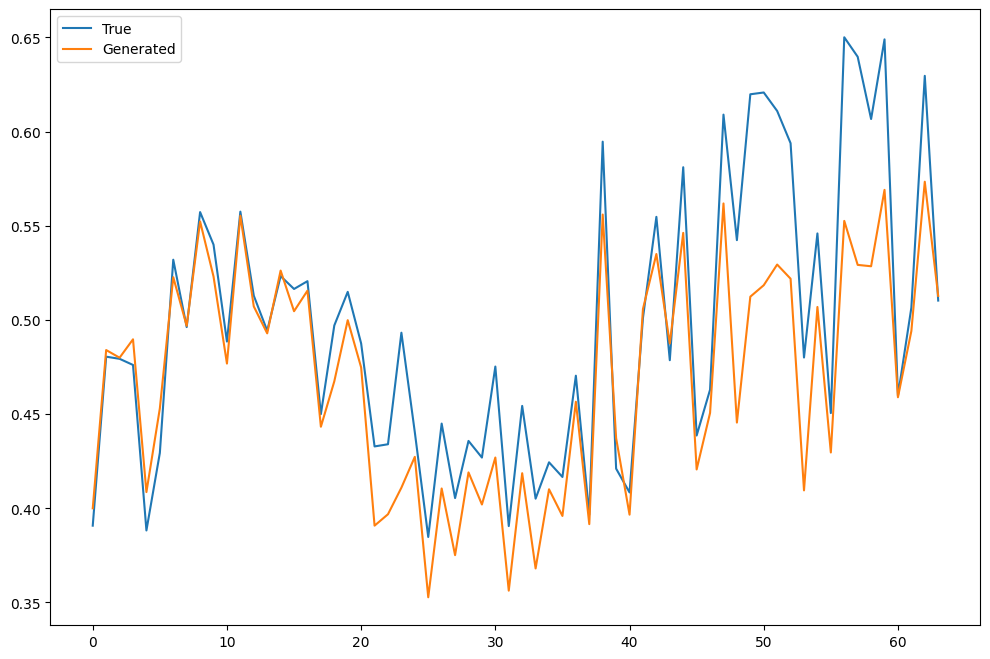

In [71]:
# Assuming cvae is your trained CVAE model
# Assuming latent_dim is the dimensionality of the latent space
num_samples = 1
cvae.eval()
randomNoise = False

outputList = []
outputListTrue = []

if(randomNoise):
    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        y_true = torch.rand(1, 64, device=device)

        # Repeat the condition tensor for each generated sample
        # Pass the latent vectors through the decoder
        generated_samples, _, _ = cvae(y_true)

        y = generated_samples.detach().cpu().numpy()[0, :]
        y_true = y_true.detach().cpu().numpy()[0, :]
else: # Test loader
    with torch.no_grad():
        test_iter = iter(test_loader)
        random_batch_idx = random.randint(0, len(test_loader) - 1)
        for batch_idx, (x, _) in enumerate(test_loader):
            if batch_idx == random_batch_idx:
                x = x.to(device=device)
                x = x[0, :].unsqueeze(0)  # Get just one sample and pass it to the network
                x_hat, _, _ = cvae(x)
                outputList.append(x_hat)
                outputListTrue.append(x)
                break

        # Example usage:
        generated_samples_torch = torch.vstack(outputList)
        true_samples_torch = torch.vstack(outputListTrue)
        print(F"Generated samples:\n\t{generated_samples_torch} | Shape: {generated_samples_torch.shape}")
        print(F"True samples:\n\t{true_samples_torch} | Shape: {true_samples_torch.shape}")

        # We take the 6th sample from the generated samples and print all the channels
        y = generated_samples_torch.detach().cpu().numpy()[0, :]
        y_true = true_samples_torch.detach().cpu().numpy()[0, :]

plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y, label='Generated')
plt.legend()
plt.show()